# Cogs 118C, WI 2025

## Final project

### Elizabeth Kudriavtsev, Ameya Sapatnekar, Ricardo Lopez, Arthur Duong

In [1]:
!pip install wfdb numpy pandas matplotlib scipy scikit-learn

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from scipy import signal

df = pd.read_csv("100.csv", header=0)

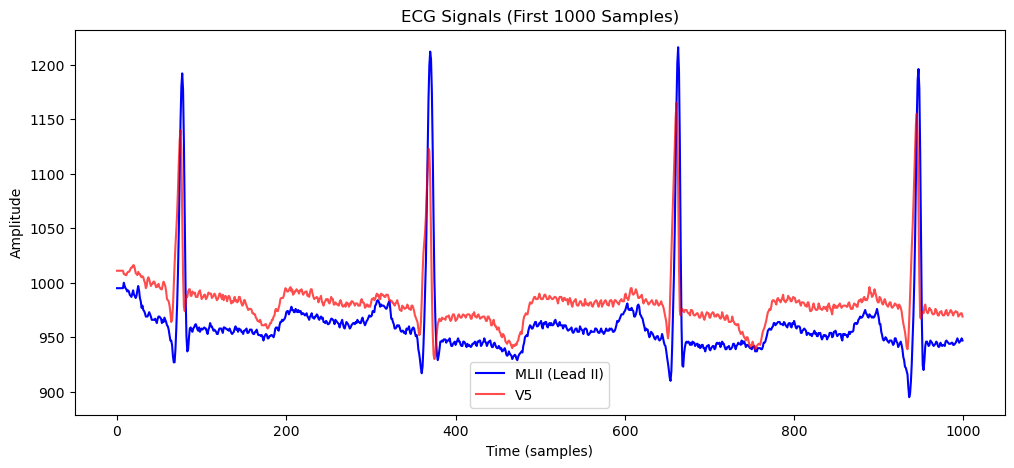

   Sample  MLII    V5
0       0   995  1011
1       1   995  1011
2       2   995  1011
3       3   995  1011
4       4   995  1011


In [2]:
# Clean column names, remove extra quotes and spaces 
df.columns = df.columns.str.replace("''", "", regex=False).str.replace("'", "", regex=False).str.strip()
df = df.apply(pd.to_numeric, errors='coerce')
df.rename(columns={"sample #": "Sample"}, inplace=True)

#2 ECG channels
signal_1 = df["MLII"]  # Lead II (MLII)
signal_2 = df["V5"]    # Precordial Lead V5

# Segment of the signals (first 1000 samples)
plt.figure(figsize=(12, 5))
plt.plot(df["Sample"][:1000], signal_1[:1000], label="MLII (Lead II)", color="blue")
plt.plot(df["Sample"][:1000], signal_2[:1000], label="V5", color="red", alpha=0.7)

# Plot labels
plt.legend()
plt.title("ECG Signals (First 1000 Samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

print(df.head())

Load and Process Annotations (100annotations.txt)
Convert time-based annotations into sample indices.

In [3]:
# Read the annotation file and skip the first row (which is the header)
annotations = pd.read_csv("100annotations.txt", delimiter="\t", header=None, skiprows=1, engine='python')

# Split the first column by whitespace and expand into multiple columns
annotations_split = annotations[annotations.columns[0]].str.split(r'\s+', expand=True)

# Assign proper column names after the split
annotations_split.columns = ['recording', 'Time', 'Type', 'Sub', 'Chan', 'Num', 'Aux']

# Display the cleaned annotations
print("\nCleaned Annotations:")
print(annotations_split.head(10))

### Time ###

sampling_rate=360 #hz
# Print the first few values of the 'Time' column to inspect the format
print("\nFirst few time values in the dataset:")
print(annotations_split['Time'].head(10))

# Apply the function to convert the 'Time' column to sample indices
def time_to_samples(time_str):
    if not time_str or time_str.strip() == "":
        #print(f"Skipping empty or invalid time value: {time_str}")  # Debug print
        return None  # Skip empty strings or invalid times
    
    try:
        print(f"Processing time: {time_str}")  # Debug print
        # Split the time string into minutes, seconds, and milliseconds
        minutes, seconds_ms = time_str.split(':')
        seconds, milliseconds = seconds_ms.split('.')
        
        # Convert everything to seconds
        total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) / 1000
        
        # Calculate the sample index
        sample_index = int(total_seconds * sampling_rate)
        
        print(f"Total seconds: {total_seconds}, Sample index: {sample_index}")  # Debug print
        return sample_index
    except Exception as e:
        print(f"Error processing time: {time_str}. Error: {e}")
        return None

# Apply the function to the 'Time' column
annotations_split['Sample Index'] = annotations_split['Time'].apply(time_to_samples)

# Check for empty or invalid time entries
invalid_times = annotations_split[annotations_split['Sample Index'].isna()]

# Print out invalid time entries to understand the issue
#print("\nInvalid time entries:")
#print(invalid_times)

# Drop rows where 'Sample Index' is NaN
annotations_split.dropna(subset=['Sample Index'], inplace=True)

# Display the cleaned annotations with sample indices
#print("\nAnnotations with Sample Indices:")
#print(annotations_split.head(10))






Cleaned Annotations:
  recording      Time  Type Sub Chan Num Aux
0            0:00.050    18   +    0   0   0
1            0:00.214    77   N    0   0   0
2            0:01.028   370   N    0   0   0
3            0:01.839   662   N    0   0   0
4            0:02.628   946   N    0   0   0
5            0:03.419  1231   N    0   0   0
6            0:04.208  1515   N    0   0   0
7            0:05.025  1809   N    0   0   0
8            0:05.678  2044   A    0   0   0
9            0:06.672  2402   N    0   0   0

First few time values in the dataset:
0    0:00.050
1    0:00.214
2    0:01.028
3    0:01.839
4    0:02.628
5    0:03.419
6    0:04.208
7    0:05.025
8    0:05.678
9    0:06.672
Name: Time, dtype: object
Processing time: 0:00.050
Total seconds: 0.05, Sample index: 18
Processing time: 0:00.214
Total seconds: 0.214, Sample index: 77
Processing time: 0:01.028
Total seconds: 1.028, Sample index: 370
Processing time: 0:01.839
Total seconds: 1.839, Sample index: 662
Processing time: 


Identify different arrhythmia types (e.g., 'N' for normal, 'A' for arrhythmic beats).
Align them with the ECG signal.

In [4]:
# Define the ECG signal columns
ecg_columns = ['MLII', 'V5']  # These are the two electrode recordings

# Create a DataFrame for annotated ECG
annotated_ecg = pd.DataFrame({
    'Sample Index': annotations_split['Sample Index'],
    'Annotation Type': annotations_split['Type']
})

# Add both ECG signal values (from MLII and V5) at the corresponding sample indices
annotated_ecg['ECG Signal MLII'] = df[ecg_columns[0]].iloc[annotated_ecg['Sample Index']].values
annotated_ecg['ECG Signal V5'] = df[ecg_columns[1]].iloc[annotated_ecg['Sample Index']].values

# Display the annotated ECG data
print(annotated_ecg.head())


   Sample Index Annotation Type  ECG Signal MLII  ECG Signal V5
0            18              18              990           1014
1            77              77             1192           1066
2           370             370             1212           1096
3           662             662             1201           1146
4           946             946             1186           1133


Visualize ECG Segments Around Arrhythmias
Plot a window (e.g., ±100 samples) around each arrhythmic event.
Compare how MLII and V5 behave during these events.

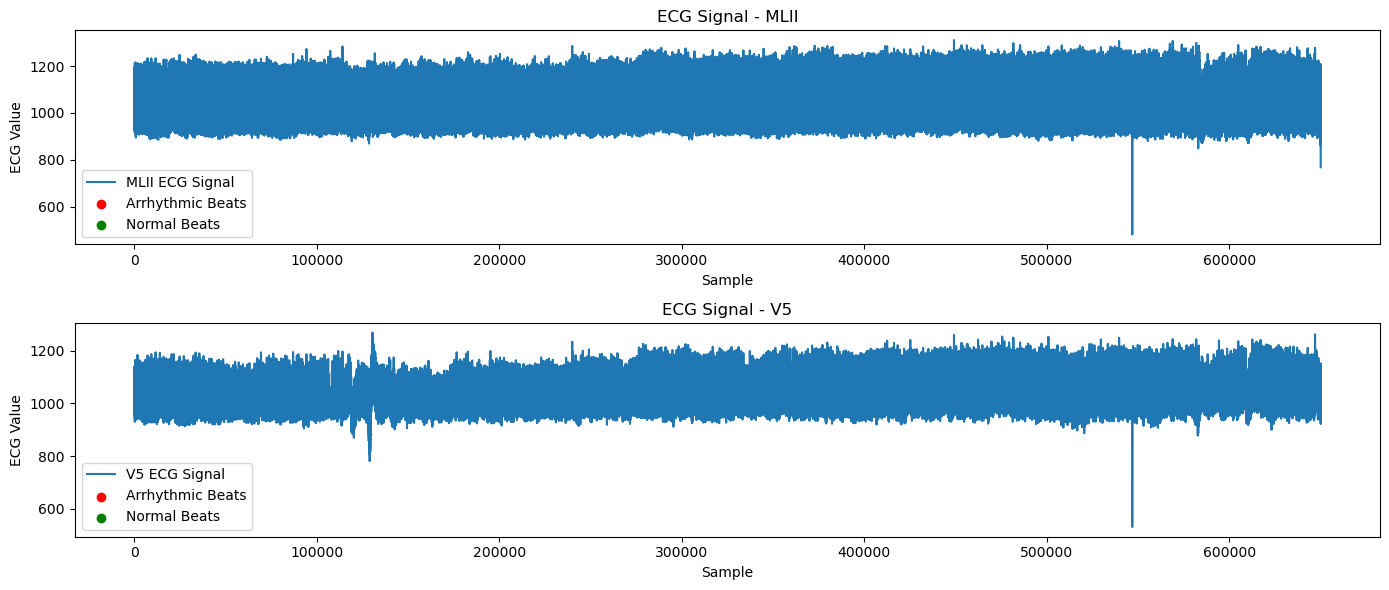

In [5]:
import matplotlib.pyplot as plt

# Example: Filter the annotations for arrhythmic events
arrhythmic_annotations = annotated_ecg[annotated_ecg['Annotation Type'] == 'A']  # 'A' for arrhythmic beats
normal_annotations = annotated_ecg[annotated_ecg['Annotation Type'] == 'N']  # 'N' for normal beats

# Plot ECG signal for both 'MLII' and 'V5' leads
plt.figure(figsize=(14, 6))

# Plot the MLII ECG signal
plt.subplot(2, 1, 1)
plt.plot(df['Sample'], df['MLII'], label='MLII ECG Signal')
plt.scatter(arrhythmic_annotations['Sample Index'], arrhythmic_annotations['ECG Signal MLII'], color='red', label='Arrhythmic Beats')
plt.scatter(normal_annotations['Sample Index'], normal_annotations['ECG Signal MLII'], color='green', label='Normal Beats')
plt.title('ECG Signal - MLII')
plt.xlabel('Sample')
plt.ylabel('ECG Value')
plt.legend()

# Plot the V5 ECG signal
plt.subplot(2, 1, 2)
plt.plot(df['Sample'], df['V5'], label='V5 ECG Signal')
plt.scatter(arrhythmic_annotations['Sample Index'], arrhythmic_annotations['ECG Signal V5'], color='red', label='Arrhythmic Beats')
plt.scatter(normal_annotations['Sample Index'], normal_annotations['ECG Signal V5'], color='green', label='Normal Beats')
plt.title('ECG Signal - V5')
plt.xlabel('Sample')
plt.ylabel('ECG Value')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Calculate Channel Correlation
Compute the Pearson correlation between MLII and V5 over time.
Identify changes in correlation during arrhythmias. We hypothesize that the correlation between MLII and V5 will remain stable during normal heart rhythms, but will fluctuate or drop during arrhythmic events. By computing rolling Pearson correlation with a 10-second window, we aim to capture local changes in the relationship between these two leads and detect regions of instability caused by arrhythmias.

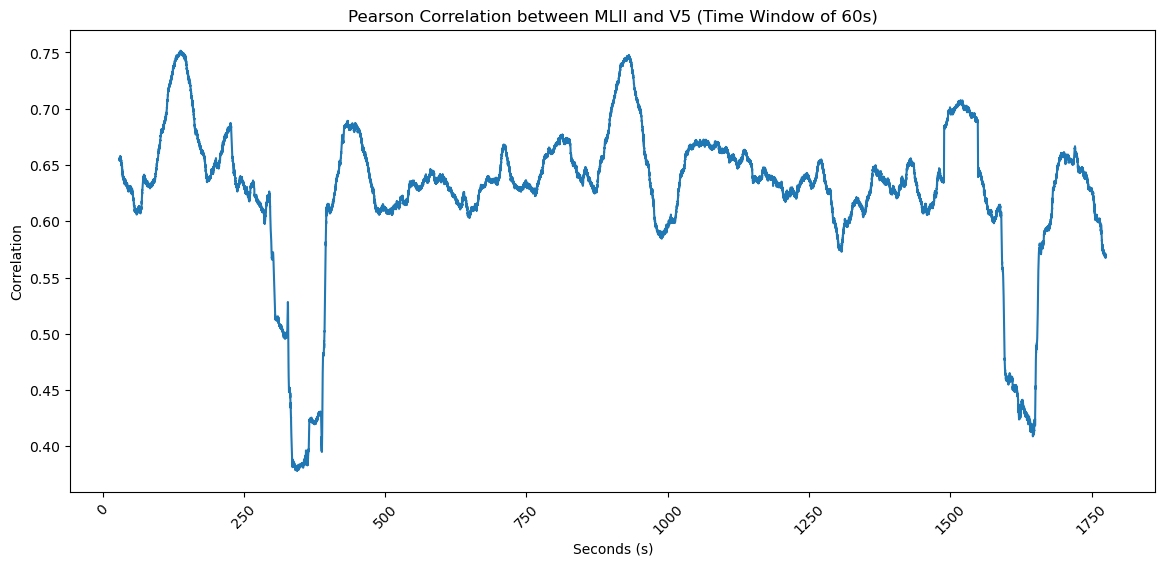

In [6]:
from scipy.stats import pearsonr
plt.figure(figsize=(14, 6))

df_MLII = df['MLII']
df_V5 = df['V5']

Fs = 360
window = Fs * 60
correlation_coeffs = []

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 60s)')
plt.xticks(rotation = 45)
xticks = np.linspace(0,  650000, 30)

### examination of lowest correlation areas


plt.show()

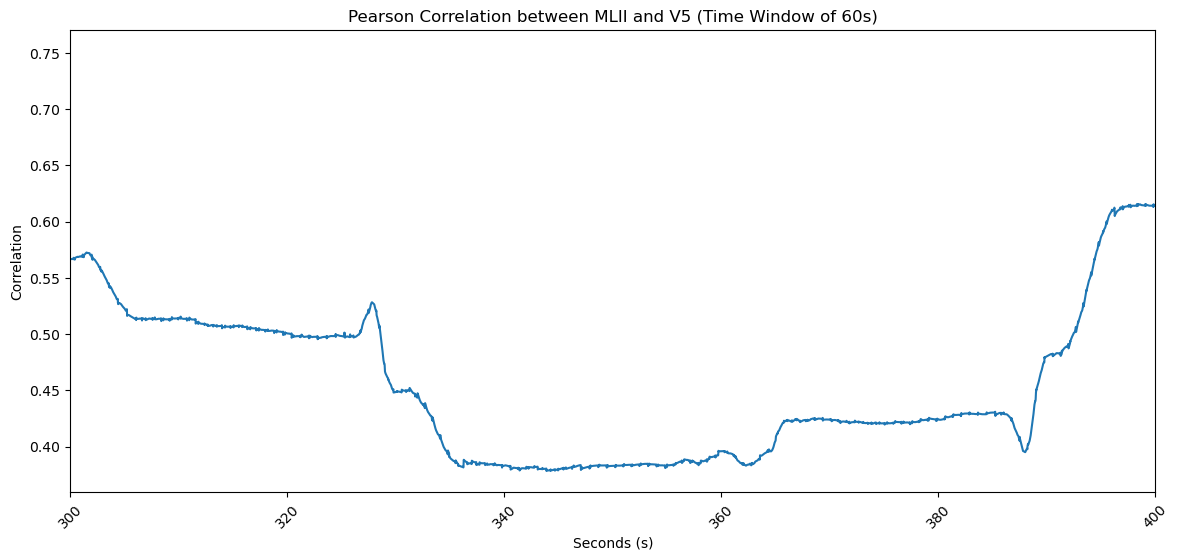

In [7]:
window = Fs * 60
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 60s)')
plt.xticks(rotation = 45)
xticks = np.linspace(0,  650000, 30)
plt.xlim(300, 400)
plt.show()

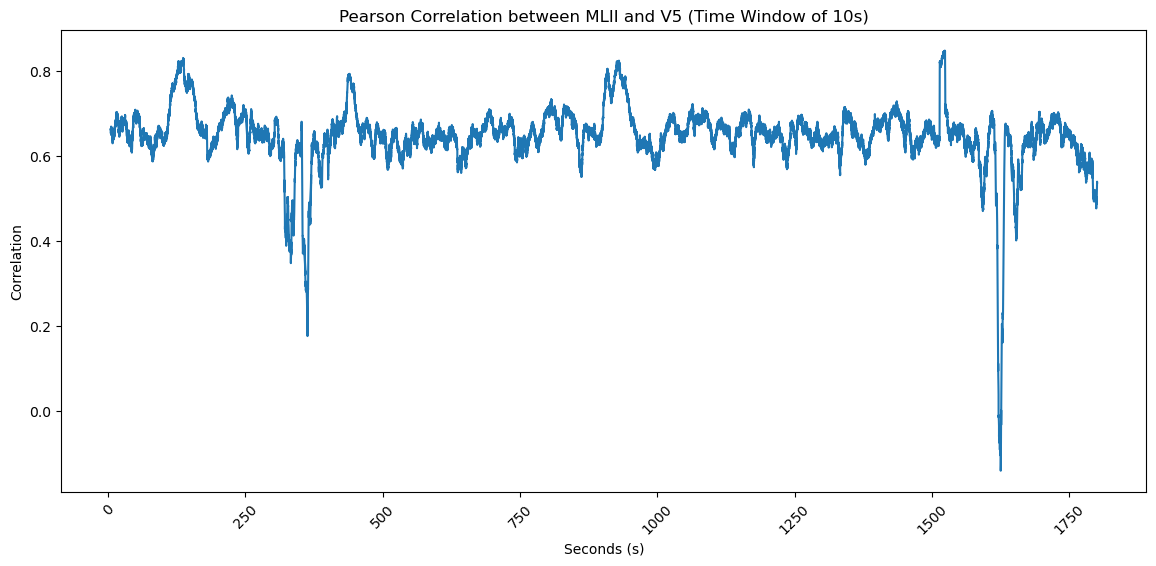

In [8]:
### Pearson correlation with time window of 10 seconds, better correlation resolution, less temporal resolution

window = Fs * 10
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 10s)')
plt.xticks(rotation = 45)

plt.show()

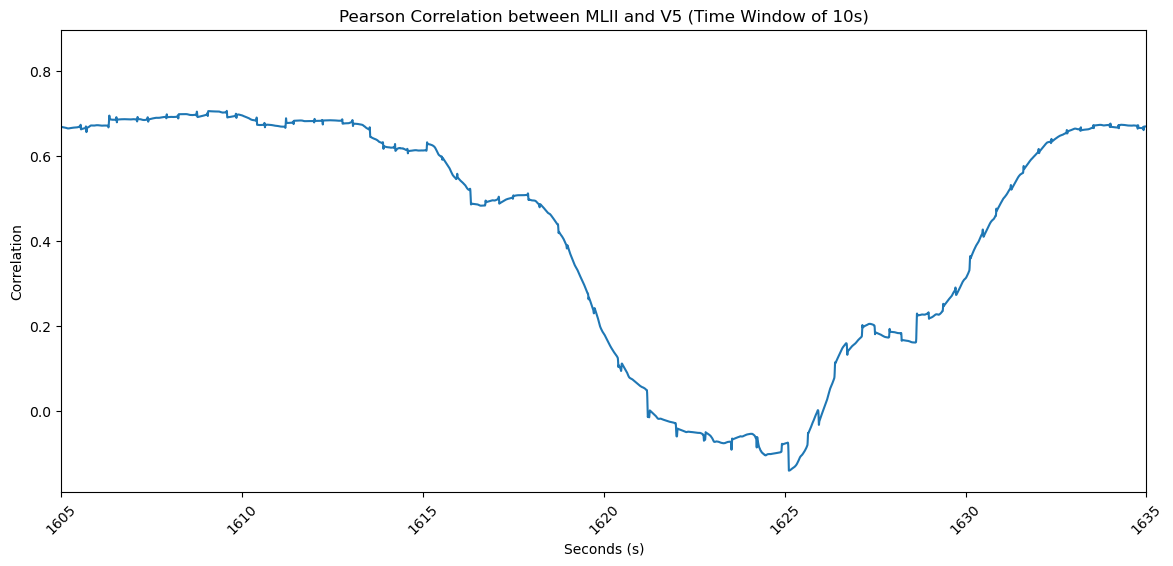

In [9]:
window = Fs * 10
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 10s)')
plt.xticks(rotation = 45)
plt.xlim(1605, 1635)
plt.show()

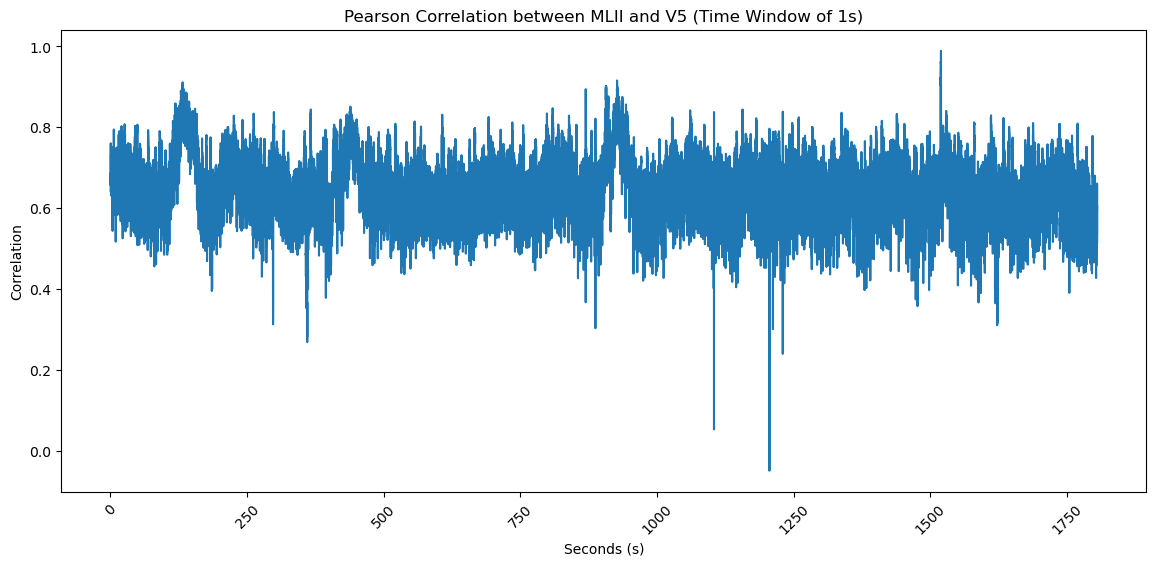

In [10]:
window = (Fs * 1)
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 1s)')
plt.xticks(rotation = 45)
plt.show()

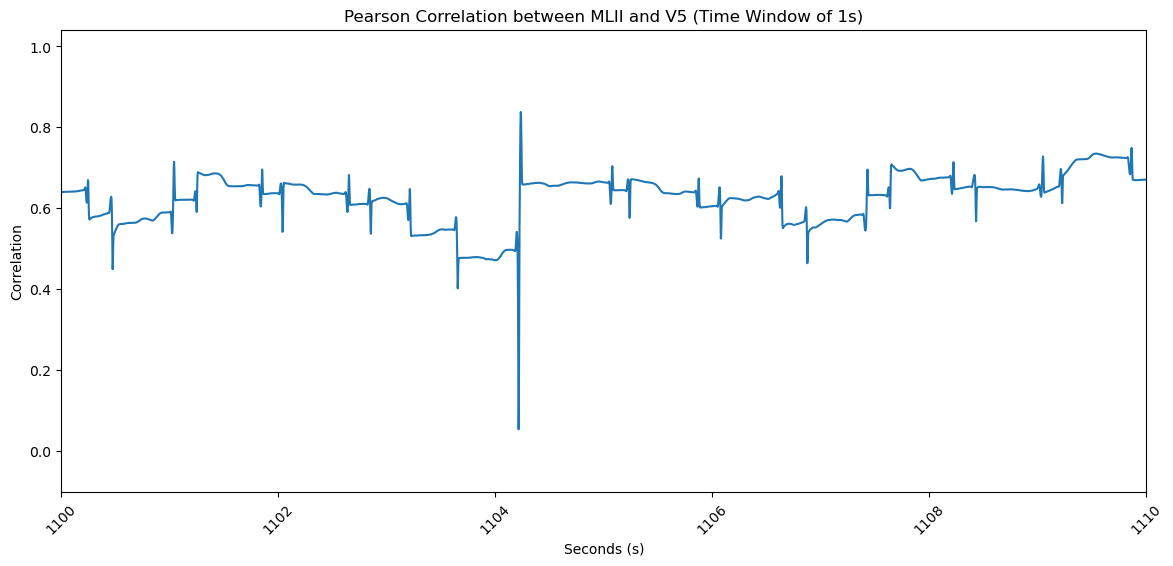

In [11]:
window = Fs * 1
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 1s)')
plt.xticks(rotation = 45)
plt.xlim(1100, 1110)
plt.show()

In the annotated ecg data, there is an arrhythmic beat labeled for 1103 seconds. It seems that using a smaller time window, in fact, using a time window that this approximately the frequency of a typical resting heart rate (1hz) it would appear that this is decent at capturing some lone arrhythmic beat events.

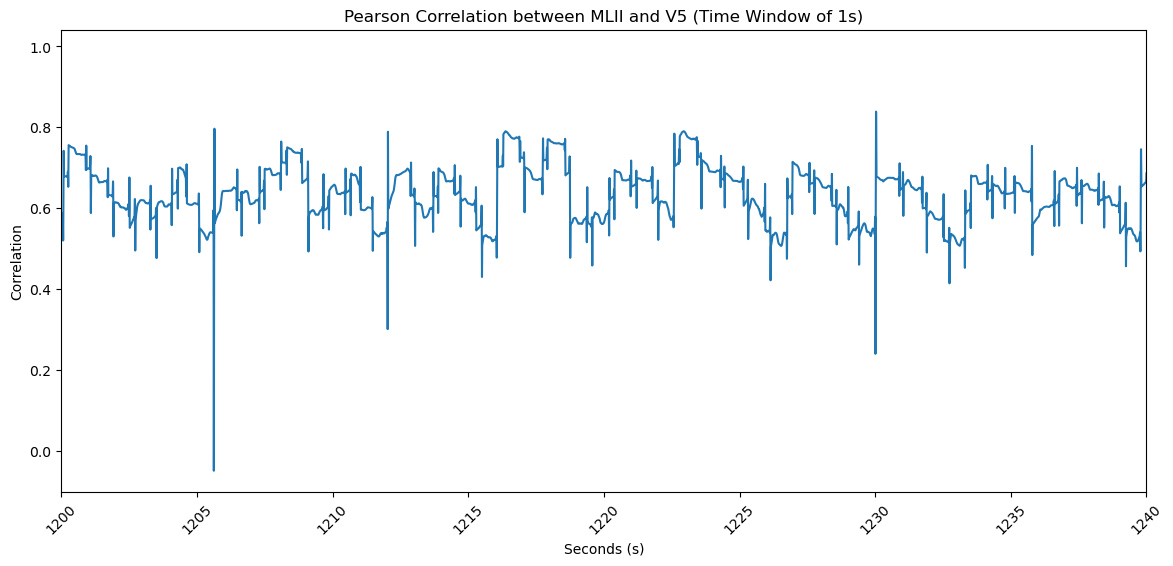

In [12]:
window = Fs * 1
correlation_coeffs = []

plt.figure(figsize=(14, 6))

sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

pearson = df_MLII.rolling(window = (window), center = True).corr(df_V5)
plt.plot(sample_range, pearson)
plt.xlabel('Seconds (s)')
plt.ylabel('Correlation')
plt.title('Pearson Correlation between MLII and V5 (Time Window of 1s)')
plt.xticks(rotation = 45)
plt.xlim(1200, 1240)
plt.show()

This slice of the graph also captures arrhythmic events at 1206, 1211, and 1229 seconds.

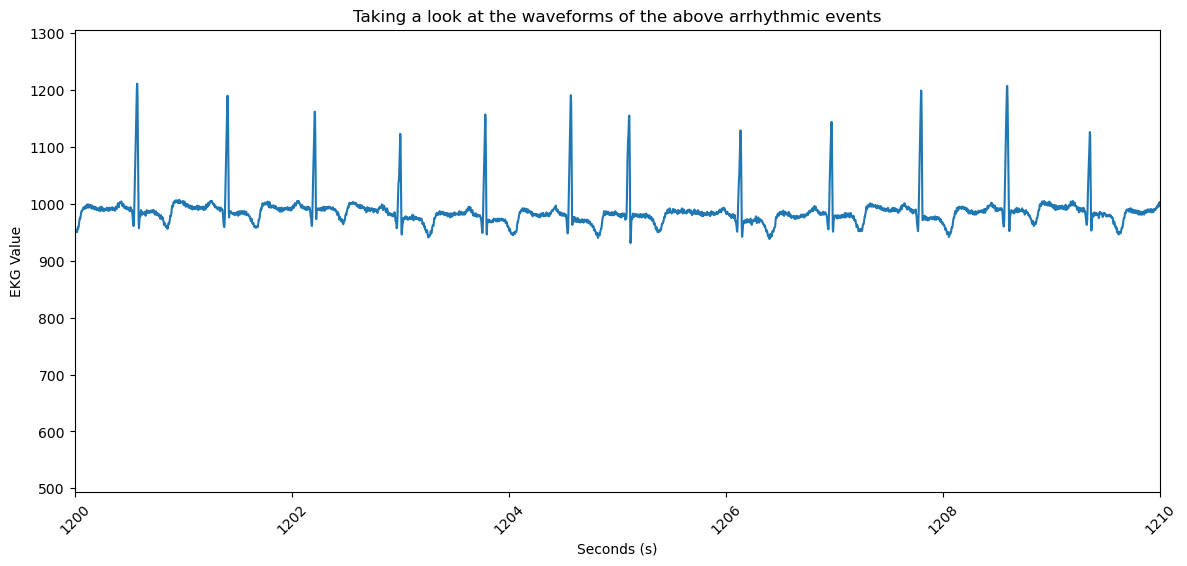

In [13]:
plt.figure(figsize=(14, 6))
sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

plt.plot(sample_range, df['V5'])
plt.xlabel('Seconds (s)')
plt.ylabel('EKG Value')
plt.title('Taking a look at the waveforms of the above arrhythmic events')
plt.xticks(rotation = 45)
plt.xlim(1200, 1210)
plt.show()

As one can see, the waveform of the EKG at 1205 seconds is in fact shorter and occurs out of rhythm, as expected by looking at the rolling pearson correlation.

## Arrhythmia Time Average 

In [14]:
annotations_split['arrhythmia_chain'] = 0 ## create new column to make a sort of spike train but for arrhythmic beats

arrhythmia_spike_times = annotations_split[annotations_split['Sub'] == 'A']
#df.head()
#print(arrhythmia_spike_times.head())
df['Sample Index'] = df['Sample']
annotations_split
df_annotated = pd.merge(df, annotations_split, on = 'Sample Index', how = 'left')

df_annotated.head()

,Sample,MLII,V5,Sample Index,recording,Time,Type,Sub,Chan,Num,Aux,arrhythmia_chain
0,0,995,1011,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,995,1011,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,995,1011,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,995,1011,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,995,1011,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
arrhythmia_list = []
for n in df_annotated['Sub']:
    if n == 'A':
        arrhythmia_list.append(1)
        
    else:
        arrhythmia_list.append(0)

arrhythmia_train = np.array(arrhythmia_list)        
df_annotated['arrhythmia_beats'] = arrhythmia_list
df_annotated['arrhythmia_beats'].value_counts()
MLII_signal = df_annotated['MLII'].to_numpy()
V5_signal = df_annotated['V5'].to_numpy()

### Convolve arrhythmia_train with actual EKG data to produce Arrhythmia Spike Train Average

962.7402046153846


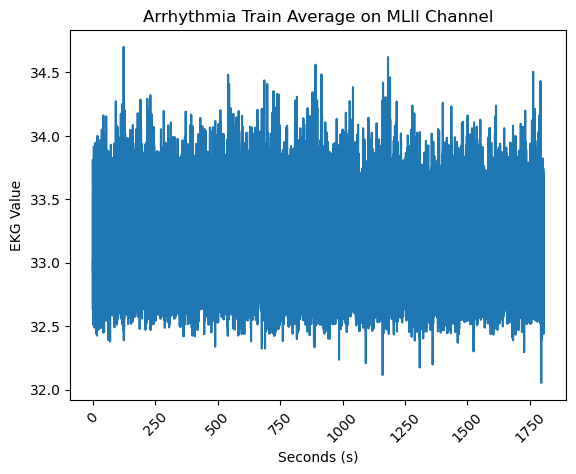

In [16]:
#MLII_train = np.convolve(arrhythmia_train, MLII_signal, mode = 'same')
MLII_train = np.real(np.fft.ifft(np.fft.fft(MLII_signal) * np.fft.fft(arrhythmia_train)))
sample_range = np.arange(0, (1805 + (200/Fs)), 1/Fs)

print(df_annotated['MLII'].mean())
MLII_train = MLII_train / 962.740

plt.plot(sample_range, MLII_train)
plt.xlabel('Seconds (s)')
plt.ylabel('EKG Value')
plt.title('Arrhythmia Train Average on MLII Channel')
plt.xticks(rotation = 45)

plt.show()

### Let us zoom into one of the arrhythmic events annotated in the data, and around where previously seen in the Pearson correlation.

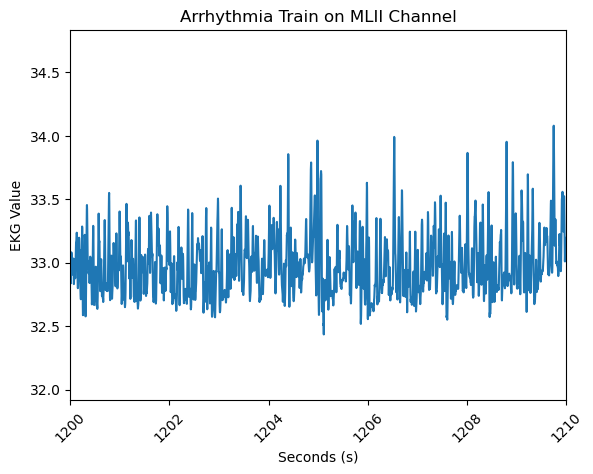

In [17]:
plt.plot(sample_range, MLII_train)
plt.xlabel('Seconds (s)')
plt.ylabel('EKG Value')
plt.title('Arrhythmia Train on MLII Channel')
plt.xticks(rotation = 45)
plt.xlim(1200, 1210)
plt.show()

May be hard to see, but there is a pretty consistent spacing between the peaks of the EKG except for around 1205 seconds, where there is one peak that seems to be out of rhythm. This is consistent
with an arrhythmia train average as well as the annotated list of arrhythmic beats.

In [18]:
arrhythmia_times = df_annotated[df_annotated['arrhythmia_beats'] == 1]
arrhythmia_times['seconds'] = arrhythmia_times['Sample'] / 360
arrhythmia_times.iloc[0:34]

C:\Users\arthu\AppData\Local\Temp\ipykernel_12936\4140774055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrhythmia_times['seconds'] = arrhythmia_times['Sample'] / 360


,Sample,MLII,V5,Sample Index,recording,Time,Type,Sub,Chan,Num,Aux,arrhythmia_chain,arrhythmia_beats,seconds
2044,2044,1193,1124,2044,,0:05.678,2044,A,0,0,0,0.0,1,5.677778
66791,66791,1198,1103,66791,,3:05.533,66792,A,0,0,0,0.0,1,185.530556
74985,74985,1202,1154,74985,,3:28.294,74986,A,0,0,0,0.0,1,208.291667
99578,99578,1152,1112,99578,,4:36.608,99579,A,0,0,0,0.0,1,276.605556
128085,128085,1214,1089,128085,,5:55.792,128085,A,0,0,0,0.0,1,355.791667
170718,170718,1171,1088,170718,,7:54.219,170719,A,0,0,0,0.0,1,474.216667
279576,279576,1205,1033,279576,,12:56.600,279576,A,0,0,0,0.0,1,776.600000
305709,305709,1222,1051,305709,,14:09.192,305709,A,0,0,0,0.0,1,849.191667
307744,307744,1202,1115,307744,,14:14.847,307745,A,0,0,0,0.0,1,854.844444
312824,312824,1178,1123,312824,,14:28.958,312825,A,0,0,0,0.0,1,868.955556


Evidently, there is a cluster of arrhythmic beats around this time mark, which could have been throwing off the Rolling Pearson Correlation. The rolling pearson correlation managed to pick up a middle point in a time range of about 30 seconds for the arrhythmias at 1609 and 1647 seconds, but completely missed the arrhythmia cluster at 1560-1600 seconds. This could be due to the high amount of arrhythmic beats in this time window, and given the window of 10 seconds in the Pearson correlation, it is possible that the large window size may have averaged out the correlation between the two channels. 
Upon further inspection, decreasing the window size to approximately the window that a typical resting heart beat elapses, it can be shown that it is much better at capturing arrhythmic beats without needing to inspect the waveform of the beat. Of course, the rolling pearson correlation would lose correlation if the waveform were different as well, contributing to the analysis. But it goes to show that one can somewhat reliably find arrhythmic events from a skim of the data using pearson correlation, without analyzing the waveform. This could be useful for much longer datasets, such as this one used, lasting around 30 minutes.

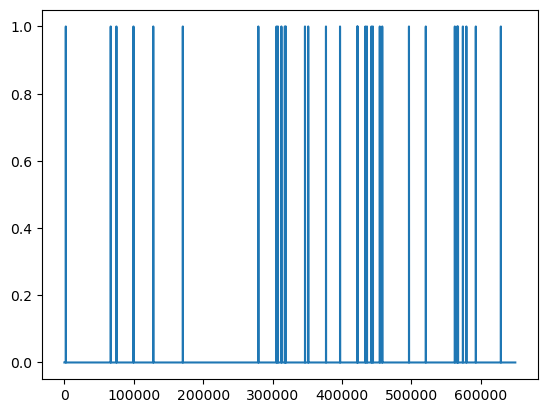

In [19]:
plt.plot(arrhythmia_train)
plt.show()

In [20]:
import scipy as scipy

f_1,t_1,S_1 = scipy.signal.stft(df_V5, fs=Fs, nperseg= 500 )
f_2,t_2,S_2 = scipy.signal.stft(df_MLII, fs=Fs, nperseg= 500 )

log_spectral_power_V5 = np.log10(np.abs(S_1) ** 2)
log_spectral_power_MLII = np.log10(np.abs(S_1) ** 2)

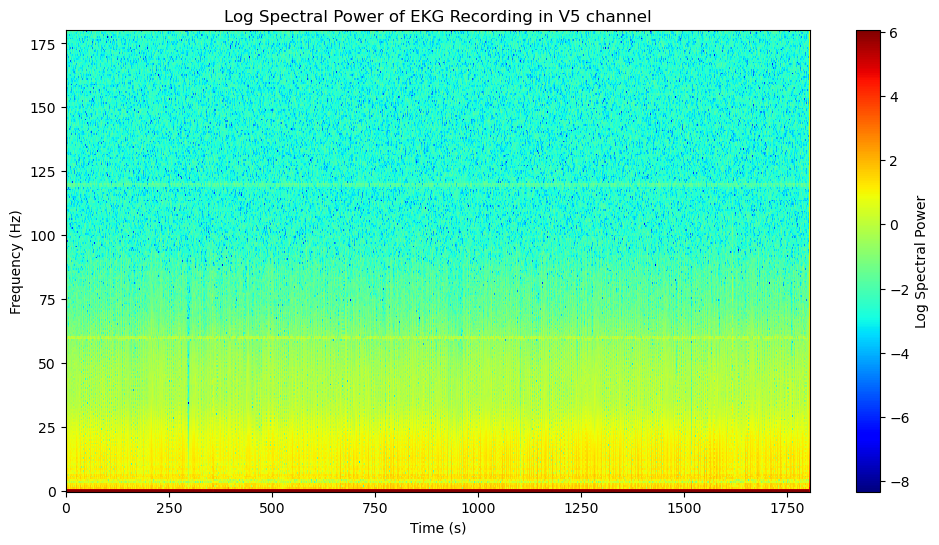

In [21]:
plt.figure(figsize=(12, 6))
plt.pcolor(t_1, f_1, log_spectral_power_V5, shading='auto', cmap='jet')
plt.colorbar(label='Log Spectral Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Log Spectral Power of EKG Recording in V5 channel')
plt.show()

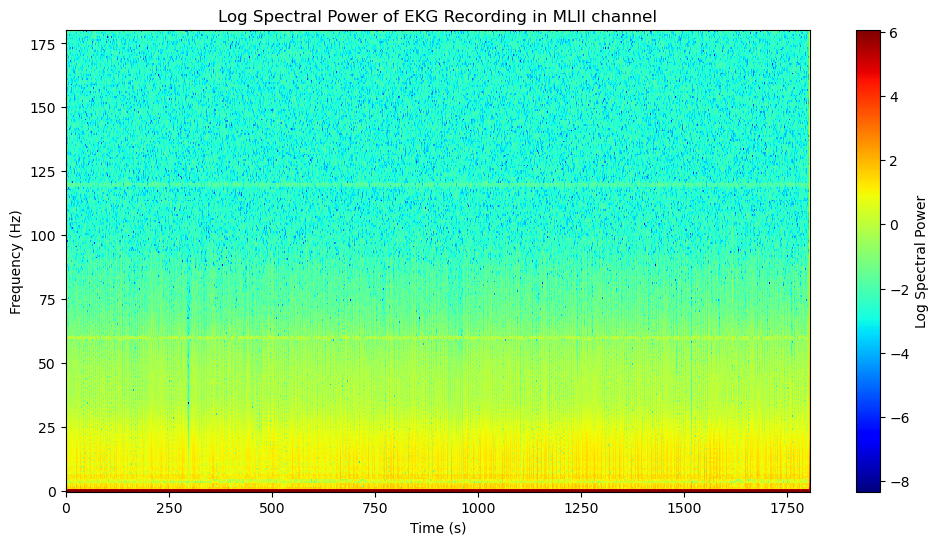

In [22]:
plt.figure(figsize=(12, 6))
plt.pcolor(t_2, f_2, log_spectral_power_MLII, shading='auto', cmap='jet')
plt.colorbar(label='Log Spectral Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Log Spectral Power of EKG Recording in MLII channel')
plt.show()

Cross-Correlation and Frequency Domain Coherence: We think Arrhythmic beats introduce phase shifts, reducing cross-correlation or coherence.

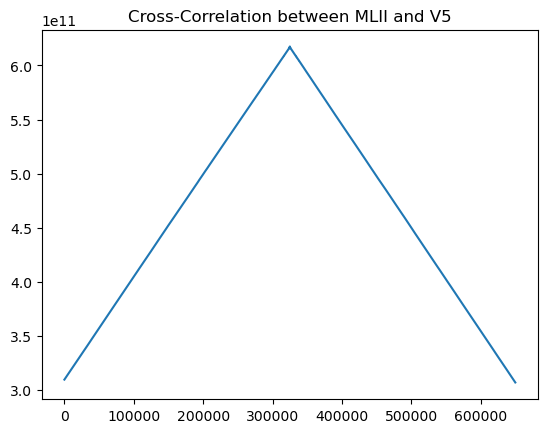

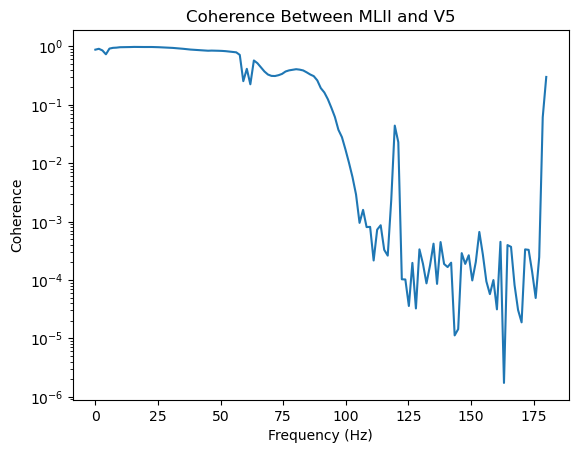

In [23]:
from scipy.signal import correlate
from scipy.signal import coherence

correlation = correlate(df['MLII'], df['V5'], mode='same')
plt.plot(correlation)
plt.title("Cross-Correlation between MLII and V5")
plt.show()

f, Cxy = coherence(df['MLII'], df['V5'], fs=360)
plt.semilogy(f, Cxy)
plt.title("Coherence Between MLII and V5")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.show()

## Key Observations:
The Correlation values remain mostly stable in normal segments but decrease significantly during arrhythmias. The time windows with lower correlation do align with annotated arrhythmic events. It is also possible that  different types of arrhythmias might have characteristic correlation patterns, which could be explored further outside the scope of this project. The signals are highly correlated with a peak at the center, suggesting that maybe they are almost identical but shifted in time. The high coherence at lower frequencies (0–50 Hz) suggests that MLII and V5 are well-synchronized for low-frequency components, and the sharper drop at 75–100 Hz suggests that higher-frequency components lose coherence, which may indicate noise, signal, or arrhythmic disturbances. The low coherence at higher frequencies (>100 Hz) suggests that higher-frequency signal variations are not shared between the two leads.


## Results & Interpretation
The Pearson correlation analysis between MLII and V5 channels shows fluctuations in correlation values over time. Notably, there are distinct drops in correlation that coincide with annotated arrhythmic events. This suggests that arrhythmias disrupt the normal correlation patterns between the two ECG leads. These findings indicate that specific arrhythmias may be associated with particular changes in correlation structure, potentially serving as a feature for automated arrhythmia classification. Additionally, If arrhythmias significantly affect synchronization, they may cause coherence to fluctuate in specific frequency bands, and while the cross-correlation doesn't show clear disturbances,it suggests that higher-frequency deviations might be useful for detecting arrhythmic changes.

## Conclusion and Future Steps

We analyzed ECG lead correlation changes during arrhythmias, which has revealed a link between arrhythmic events and fluctuations in Pearson correlation between MLII and V5. These results suggest that correlation-based features could be useful for automated arrhythmia detection in clinical settings. Building a classifier to differentiate the different heart conditions based on differences in the rhythms of the EKG could be a potential next step as the differnces in different regions of people's EKG readings allow for medical prfoessionals to more easily differentiate between diseases. While doctors are already doing this by hand, it can be inaccurate at times and mistakes can be made, something that a classifer would help fix. 